# Topic Modeling (Prepare)

We talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: Who might want to know that in industry - 
* Identifying common themes in customer reviews
* Discovering the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
* Part 0: Warm-Up
* Part 1: Describe how an LDA Model works
* Part 2: Estimate an LDA Model with Gensim
* Part 3: Interpret LDA results & Select the appropriate number of topics

# Part 0: TfidfVectorizer
First we use sklearn TfidfVectorizer() to create a doc term matrix, dtm. And use that with a classifier.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# this is the dataset that we'll be using for topic modeling as well 
# RUNTIME ISSUE ADVICE: 
# IF YOUR CODE TAKES TOO LONG TO RUN, TRY TAKING A RANDOM SUBSAMPLE OF THE DATA. GET EVERYTHING TO RUN ON A SMALL DATASET, ONCE THAT WORKS INCREASE THE SIZE OF THE DATASET
# ALTERNATIVELY, YOU COULD WORK WITH 3 OR 4 TOPICS INSTEAD OF ALL 20

# for simplicity, I'm going to only work with 3 topics 
categories = ["comp.sys.mac.hardware", 
              "comp.graphics", 
              "sci.space"]
data = fetch_20newsgroups(categories=categories)

In [4]:
data.target[:5]

array([1, 2, 1, 2, 0])

In [6]:
# respectively associated with target labels
data.target_names

['comp.graphics', 'comp.sys.mac.hardware', 'sci.space']

In [9]:
data['data'][1000]

"From: ayr1@cunixa.cc.columbia.edu (Amir Y Rosenblatt)\nSubject: Power Supplies for Mac 512's\nSummary: I need them\nNntp-Posting-Host: cunixa.cc.columbia.edu\nReply-To: ayr1@cunixa.cc.columbia.edu (Amir Y Rosenblatt)\nOrganization: Columbia University\nLines: 13\n\n\nI thnik i'll be able to pick up  a piar of Mac 512K's for nothing, but\ntheir power supplies are dead.  Anyone know where I can pick up a pair\nof refurbished PS's for cheap (preferably mail order).\nYes, I do have uses planned fior them.  One will be sold to a friend who\njust needs a terminal to connect via modem to his e-mail account.\nThe other will be used by me as a net client to run my downloads and/or\nprinting.\n  \nAlso, what is the latest system software usable with these suckers?\n\n\n\n"

### GridSearch on Just Classifier
* Fit the vectorizer and prepare BEFORE it goes into the gridsearch

In [10]:
v1 = TfidfVectorizer(stop_words="english")
X = data['data'] # raw text data
X_train = v1.fit_transform(X)

In [19]:
type(X), len(X)

(list, 1755)

In [13]:
type(X_train), X_train.shape # doc-term matrix

(scipy.sparse.csr.csr_matrix, (1755, 28321))

In [20]:
# parameter dict
p1 = {
    'n_estimators':[10,20],
    'max_depth': [None, 7]
}

In [21]:
clf = RandomForestClassifier()
gs1 = GridSearchCV(clf, p1, cv=5,n_jobs=-1, verbose=1)
gs1.fit(X_train, data['target'])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [22]:
user_data_from_website = ["I like medical science and doctors and good health."]
test_sample = v1.transform(user_data_from_website)
test_sample.shape

(1, 28321)

In [25]:
test_sample.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

In [26]:
pred = gs1.predict(test_sample)
pred

array([0])

In [27]:
data['target_names'][pred[0]]

'comp.graphics'

### GridSearch with BOTH the Vectoizer & Classifier

In [28]:
from sklearn.pipeline import Pipeline

v2 = TfidfVectorizer()
clf = RandomForestClassifier()

pipe = Pipeline([
    ('vect', v2),
    ('clf', clf)
])

p2 = {
    'vect__max_features':[1000,5000],
    'clf__n_estimators':[10,20],
    'clf__max_depth': [None, 7]
}

gs2 = GridSearchCV(pipe, p2, cv=5,n_jobs=-1, verbose=1)
gs2.fit(data['data'], data['target'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [32]:
pred = gs2.predict(user_data_from_website)

In [33]:
data['target_names'][pred[0]]

'comp.graphics'

Advantages to using GS with the Pipe:
* Allows us to make predictions on raw text increasing reproducibility.
* Allows us to tune the parameters of the vectorizer along side the classifier.

# Part 1: Creating dictionary (id2word) and dtm(corpus) with gensim

[Your Guide to Latent Dirichlet Allocation](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d)

[LDA Topic Modeling](https://lettier.com/projects/lda-topic-modeling/)

[Topic Modeling with Gensim](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

In [34]:
# # Download spacy model
# alternative way to download the pre-trained model
# import spacy.cli
# spacy.cli.download("en_core_web_lg")

In [35]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# these are all gensim imports 
# check out the gensim docs: https://radimrehurek.com/gensim/
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# we use spacy to load in the word2vec model 
import spacy

# all these imports are for the data viz tool that we use to look at the LDA results and manually determine the topics in our dataset 
# check out the docs: https://pyldavis.readthedocs.io/en/latest/readme.html
# the docs also have an EXAMPLE NOTEBOOK that is more detailed about this data viz tool than our lecture notebook: https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
# load text data into dataframe because pandas dataframes are our prefered way to perform data manipulations 
df = pd.DataFrame({
    'content': data['data'],
    'target': data['target'],
    'target_names': [data['target_names'][i] for i in data['target']]
})

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
df.head()

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,target,target_names
0,From: meharg@kits.sfu.ca (Gersham William Meha...,1,comp.sys.mac.hardware
1,From: sheaffer@netcom.com (Robert Sheaffer)\nS...,2,sci.space
2,From: winstead@faraday.ece.cmu.edu (Charles Ho...,1,comp.sys.mac.hardware
3,From: ralph.buttigieg@f635.n713.z3.fido.zeta.o...,2,sci.space
4,From: ednobles@sacam.OREN.ORTN.EDU (Edward d N...,0,comp.graphics


#### Some data cleaning before modeling

In [48]:
text = "vnrn rnv@ejnr 23hfh evn@vn.ven devnvn"
re.sub('\S+@\S+', '', text)

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:2: DeprecationWarning: invalid escape sequence \S
<>:2: DeprecationWarning: invalid escape sequence \S
<>:2: DeprecationWarning: invalid escape sequence \S
<ipython-input-48-5c5193c51fbc>:2: DeprecationWarning: invalid escape sequence \S
  re.sub('\S+@\S+', '', text)


'vnrn  23hfh  devnvn'

In [50]:
# my advise is to create a function called clean_data 
# where all cleaning transformations happen in that function
# and you only have to call the .apply() method once

def clean_data(text):
    # Remove whitespace
    text = text.strip()
    # Remove Emails. \S: non-space character, + is match one or more
    # default is count=0 and replaces as many non overlapping match as it finds
    text = re.sub(r'From: \S+@\S+', '', text, count=0)    
    # Replace new line and other characters with single space. \s: space character
    text = re.sub(r'\s+', ' ', text)
    # Remove non-alphanumeric characters
    text = re.sub(r'[^0-9 a-zA-Z]+', '', text)
    return text 

df['content'] = df['content'].apply(lambda row: clean_data(row))


/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
df.head()

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,target,target_names
0,Gersham William Meharg Subject Re Centris 610 ...,1,comp.sys.mac.hardware
1,Robert Sheaffer Subject Re Astronomy Program O...,2,sci.space
2,Charles Holden Winstead Subject ftp site for R...,1,comp.sys.mac.hardware
3,Ralph Buttigieg Subject Why not give 1 billion...,2,sci.space
4,Edward d Nobles Subject windows imagine Organi...,0,comp.graphics


In [53]:
# if running locally on your laptop, it would be wise to take advantage of this parallelization tool
# if running on Colab (which only has 2 cores), this tool might not be of use 

# check out the docs: https://github.com/nalepae/pandarallel/tree/v1.5.1
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True, nb_workers=10 )

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
# load 
nlp = spacy.load("en_core_web_lg")

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Tokenize our cleaned up text data with spacy's token.lemma_

In [55]:
# we are using spacy here to tokenize the text (after having cleaned the text)
# what we are NOT using spacy for is to get those 300 dim vectors
# LDA needs term frequencies, which the word2vec embedings are not 
#%%time

# choosing to not use pandarallel here 
df['lemmas'] = df['content'].apply(lambda doc: [
    token.lemma_ for token in nlp(doc) if (token.is_stop != True) and (token.is_punct != True)])

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
df.head()

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,target,target_names,lemmas
0,Gersham William Meharg Subject Re Centris 610 ...,1,comp.sys.mac.hardware,"[Gersham, William, Meharg, Subject, Centris, 6..."
1,Robert Sheaffer Subject Re Astronomy Program O...,2,sci.space,"[Robert, Sheaffer, Subject, Astronomy, Program..."
2,Charles Holden Winstead Subject ftp site for R...,1,comp.sys.mac.hardware,"[Charles, Holden, Winstead, subject, ftp, site..."
3,Ralph Buttigieg Subject Why not give 1 billion...,2,sci.space,"[Ralph, Buttigieg, Subject, 1, billion, yearlo..."
4,Edward d Nobles Subject windows imagine Organi...,0,comp.graphics,"[Edward, d, Nobles, Subject, window, imagine, ..."


### The two main inputs to the LDA topic model are the dictionary (id2word) and the corpus (dtm).

In [97]:
## the LDA model wants id2word and corpus as input 

# Create Dictionary
# pass in tokens 

# check out docs for corpora.Dictionary: https://radimrehurek.com/gensim/corpora/dictionary.html
id2word = corpora.Dictionary(df['lemmas'] )



/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:
[id2word[i] for i in range(10)]

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['1', '16', '4160', '4fg', '610', '832x624', '8bit', 'BC', 'Burnaby', 'Canada']

In [99]:
# Filters out the bad tokens
id2word.filter_tokens(bad_ids=[0,1,2,3,4,5])
[id2word[i] for i in range(10)]

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['8bit',
 'BC',
 'Burnaby',
 'Canada',
 'Centris',
 'Distribution',
 'Fraser',
 'Gersham',
 'Lines',
 'Meharg']

In [100]:
[id2word[i] for i in range(len(id2word)-10, len(id2word),1)]

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['MacDac',
 'Smilor',
 'applyi',
 'internship',
 'msmilorskatuscedu',
 'ng',
 'nyone',
 'skat1psaifINNfc5',
 'skatuscedu',
 'smiloraludrauscedu']

In [101]:
# Document Term Frequency (Counter)
corpus = [id2word.doc2bow(text) for text in df['lemmas']]

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [102]:
len(corpus), len(df)

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1755, 1755)

In [103]:
doc_id = 400
corpus[doc_id]

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(8, 1),
 (11, 1),
 (17, 1),
 (18, 1),
 (117, 1),
 (147, 1),
 (149, 1),
 (154, 1),
 (251, 1),
 (259, 1),
 (261, 1),
 (279, 1),
 (357, 2),
 (442, 1),
 (497, 2),
 (563, 1),
 (571, 2),
 (712, 1),
 (882, 1),
 (885, 1),
 (902, 1),
 (1588, 1),
 (2188, 1),
 (2231, 1),
 (3413, 1),
 (3451, 1),
 (3508, 1),
 (3843, 1),
 (4951, 1),
 (5647, 1),
 (8929, 2),
 (10440, 1),
 (10710, 1),
 (10711, 2),
 (10712, 1),
 (10713, 1),
 (10714, 2),
 (10916, 1),
 (12849, 1),
 (12850, 1),
 (12851, 1),
 (12852, 1),
 (12853, 1),
 (12854, 1),
 (12855, 1)]

All we're doing in the cells between `id2word[200]` and `[(id2word[word_id], word_count) for word_id, word_count in corpus[5]]` is exploring how the objects we just created `id2word` and `corpus` are storing the tokens. Take some time to simply explore these objects, you might need to look up the documenation to get familar with these objects. These objects store our tokens and give them certain functionality that the LDA model needs in order to run. Thats' all. 

In [104]:
id2word[200]

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'cost'

In [105]:
df['content'][5]

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Pat Subject Re Keeping Spacecraft on after Funding Cuts Organization Express Access Online Communications USA Lines 11 Distribution world NNTPPostingHost accessdigexnet Some birds require constant management for survival Pointing a sensor at the sun even when powered down may burn it out Pointing a parabolic antenna at Sol from venus orbit may trash the foci elements Even if you let teh bird drift it may get hosed by some cosmic phenomena pat'

In [106]:
df["lemmas"][5][:5], len(df["lemmas"][5])

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(['Pat', 'Subject', 'keep', 'Spacecraft', 'Funding'], 45)

In [107]:
corpus[5][:5], len(corpus[5])

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


([(8, 1), (11, 1), (17, 1), (66, 1), (113, 1)], 43)

In [108]:
# Human readable format of corpus (term-frequency)
[(id2word[word_id], word_count) for word_id, word_count in corpus[5][:5]]

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('Lines', 1), ('Organization', 1), ('Subject', 1), ('Online', 1), ('sun', 1)]

# Part 2: Estimate an LDA Model with Gensim

 ### Train an LDA model

In [109]:
%%time

# even if you're running this notebook on CoLab (which only has 2 cores), you might still benefit from running this multicore version of the model
# If you prefer, you can ignore this cell and use the non-multicore version of the model in the above cell. 

lda_multicore = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics = 3,
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=10) # change workers to be N - 1, where N is the total number of cores that your computer has 
lda_multicore.save('lda_multicore.model')
# https://radimrehurek.com/gensim/models/ldamulticore.html

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 4.01 s, sys: 580 ms, total: 4.59 s
Wall time: 4.8 s


In [110]:
# it's a good idea to save the model to file
from gensim import models
lda_multicore =  models.LdaModel.load('lda_multicore.model')

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
from pprint import pprint

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### View the topics in LDA model

In [112]:
# here we are printing out the topic indices and the 10 most occuring tokens for each topic
# this is one way to determine what topics you should create
# However a much better way is to use the data viz tool below
pprint(lda_multicore.print_topics())

[(0,
  '0.006*"Organization" + 0.005*"Space" + 0.005*"Subject" + 0.005*"space" + '
  '0.004*"launch" + 0.004*"not" + 0.004*"write" + 0.004*"NASA" + 0.003*"line" '
  '+ 0.003*"Lines"'),
 (1,
  '0.010*"not" + 0.009*"Organization" + 0.008*"Subject" + 0.007*"write" + '
  '0.006*"Lines" + 0.005*"know" + 0.004*"University" + 0.004*"line" + '
  '0.004*"article" + 0.004*"problem"'),
 (2,
  '0.005*"Organization" + 0.005*"write" + 0.005*"image" + 0.004*"Subject" + '
  '0.004*"not" + 0.004*"line" + 0.004*"use" + 0.003*"system" + '
  '0.003*"University" + 0.003*"Lines"')]


/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [113]:
doc_lda = lda_multicore[corpus]

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [116]:
len(doc_lda)

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1755

In [135]:
# [(document topic, topic weight)]
# [word index, word topic]
# for doc0
doc_lda[0]

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


([(1, 0.25039184), (2, 0.7424954)],
 [(0, [2, 1]),
  (1, [2, 1]),
  (2, [2]),
  (3, [2, 1]),
  (4, [2, 1]),
  (5, [2, 1]),
  (6, [2, 1]),
  (7, [2, 1]),
  (8, [2, 1]),
  (9, [2, 1]),
  (10, [2, 1]),
  (11, [2, 1]),
  (12, [2, 1]),
  (13, [2, 1]),
  (14, [2, 1]),
  (15, [1, 2]),
  (16, [2, 1]),
  (17, [2, 1]),
  (18, [2, 1]),
  (19, [2, 1]),
  (20, [2, 1]),
  (21, [1, 2]),
  (22, [2, 1]),
  (23, [2, 1]),
  (24, [2, 1]),
  (25, [2, 1]),
  (26, [1, 2]),
  (27, [1, 2]),
  (28, [1, 2]),
  (29, [2, 1]),
  (30, [2, 1]),
  (31, [2, 1]),
  (32, [2, 1]),
  (33, [2, 1]),
  (34, [2, 1]),
  (35, [2, 1]),
  (36, [2, 1]),
  (37, [2, 1]),
  (38, [2, 1]),
  (39, [2, 1]),
  (40, [2, 1]),
  (41, [2, 1]),
  (42, [2, 1]),
  (43, [2, 1])],
 [(0, [(1, 0.096580245), (2, 0.9030561)]),
  (1, [(1, 0.0374899), (2, 0.96082133)]),
  (2, [(2, 0.9937201)]),
  (3, [(1, 0.32170418), (2, 1.6762093)]),
  (4, [(1, 0.5800923), (2, 1.4195219)]),
  (5, [(1, 0.31945893), (2, 0.6792855)]),
  (6, [(1, 0.16739184), (2, 0.8287923

### What is topic Perplexity?
**Perplexity** is a statistical measure of how well a probability model predicts a sample. As applied to LDA, for a given value of , you estimate the LDA model. Then given the theoretical word distributions represented by the topics, compare that to the actual topic mixtures, or distribution of words in your documents.

Lower values of perplexity indicate lower misrepresentation of the words of the test documents by the trained topics.

However, the statistic is somewhat meaningless on its own. The benefit of this statistic comes in comparing perplexity across different models with varying scores. The model with the lowest perplexity is generally considered the “best”.

### What is topic coherence?
Topic Coherence score measures a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is “the game is a team sport”, “the game is played with a ball”, “the game demands great physical efforts”

In [136]:

# Compute Perplexity
# you can compute perplexity easily because it's a model attribute
print('\nPerplexity: ', lda_multicore.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
# to calculate Coherence, you need to import CoherenceModel from gensim 
coherence_model_lda = CoherenceModel(model=lda_multicore, 
                                     texts=df['lemmas'], 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -8.856354670866946

Coherence Score:  0.4707441338557459


# Part 3: Interpret LDA results & Select the appropriate number of topics

In [137]:
# this is a super useful tool for helping you determine names of topics 
# recall that you can click on 2.relevance in the bottom right-hand corner 
# to view the white paper to help you understand why lambda = 0.60 is optimial 
# this tool is taking a high dim dataset and projecting it into 2 dim in order to visualize it
# each blue circle is a potential topic with corresponding words and their frequencies
# ideally, there would be little overlap between topics (i.e. we want topics to be distinct)
# to help this, we should clean the data well, train the model well, 
# however sometimes a document is meaningfully related to multiple topics 
# so this is one reason why human eyes need to be involved in this process (i.e. human judgement)


# the 3 topics that I'm workign with here don't overlap at all 

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore,
                              corpus, 
                              id2word)
pyLDAvis.save_html(vis, "./topics3.html")

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [138]:
# after training an LDA model, and if you have time, you can use this function 
# to try to find the ideal number of topics for your dataset

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=12)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [139]:
%%time
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word, corpus=corpus, texts=df['lemmas'], start=2, limit=7, step=1)

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 47.7 s, sys: 10 s, total: 57.7 s
Wall time: 35.8 s


In [140]:
coherence_values

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.4452381546053546,
 0.47487425537132727,
 0.5235746030786393,
 0.49770685825810307,
 0.49302621965995463]

/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


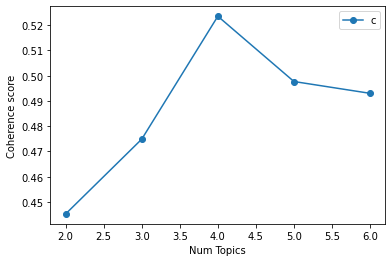

In [141]:
"""
recall that the higher the coherence score the better (meaning that the terms in the topic 
are related). The plot below shows that the highest scores correspond to a number of topics 
between 20 and 25
again, this a human-in-the-loop process, you can't rely on a measurement alone to determine 
the ideal number of topics
because of the 3 topics that I'm working with here don't really don't overlap, there is a 
clear winning for the ideal number of topics 
"""

limit=7; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values, "o-")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [142]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4452
Num Topics = 3  has Coherence Value of 0.4749
Num Topics = 4  has Coherence Value of 0.5236
Num Topics = 5  has Coherence Value of 0.4977
Num Topics = 6  has Coherence Value of 0.493


/Users/shahnam/opt/anaconda3/envs/ML_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
